In [1]:
import numpy as np
import pandas as pd 
import os
import itertools
import librosa
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

def analyze_audio(audio_path):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=None, mono=True)

    # Calculate basic statistics
    duration = librosa.get_duration(y=y, sr=sr)
    rms = librosa.feature.rms(y=y)
    zcr = librosa.feature.zero_crossing_rate(y)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

    # Spectrogram
    plt.figure(figsize=(10, 6))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

    # Waveform
    plt.figure(figsize=(10, 6))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.show()

    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.show()

    # Chroma features
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
    plt.colorbar()
    plt.title('Chroma Features')
    plt.show()

    # Spectral contrast
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(spectral_contrast, x_axis='time', y_axis='linear')
    plt.colorbar()
    plt.title('Spectral Contrast')
    plt.show()

    # Spectral centroid
    plt.figure(figsize=(10, 6))
    plt.semilogy(spectral_centroid.T, label='Spectral Centroid')
    plt.ylabel('Hz')
    plt.xticks([])
    plt.xlim([0, spectral_centroid.shape[-1]])
    plt.legend()
    plt.title('Spectral Centroid')
    plt.show()

    return {
        'duration': duration,
        'mean_rms': np.mean(rms),
        'mean_zero_crossing_rate': np.mean(zcr),
        'mean_chroma': np.mean(chroma),
        'mean_spectral_contrast': np.mean(spectral_contrast),
        'mean_spectral_centroid': np.mean(spectral_centroid),
    }


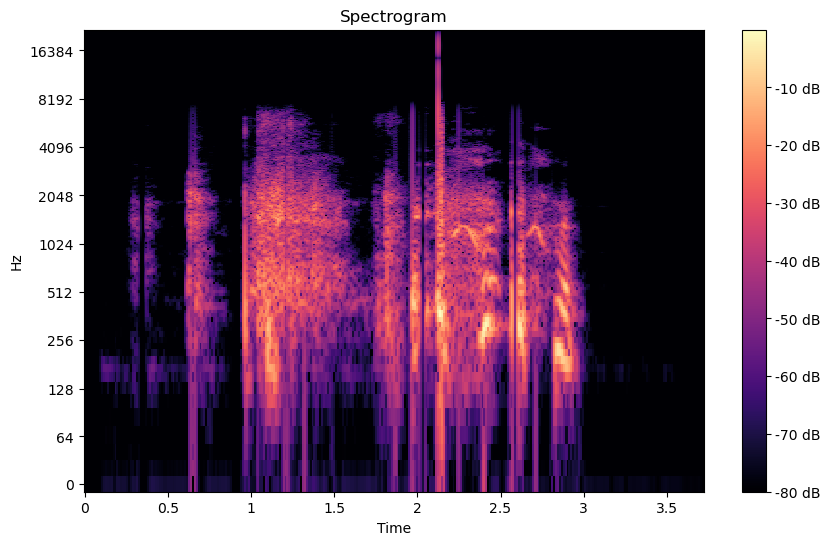

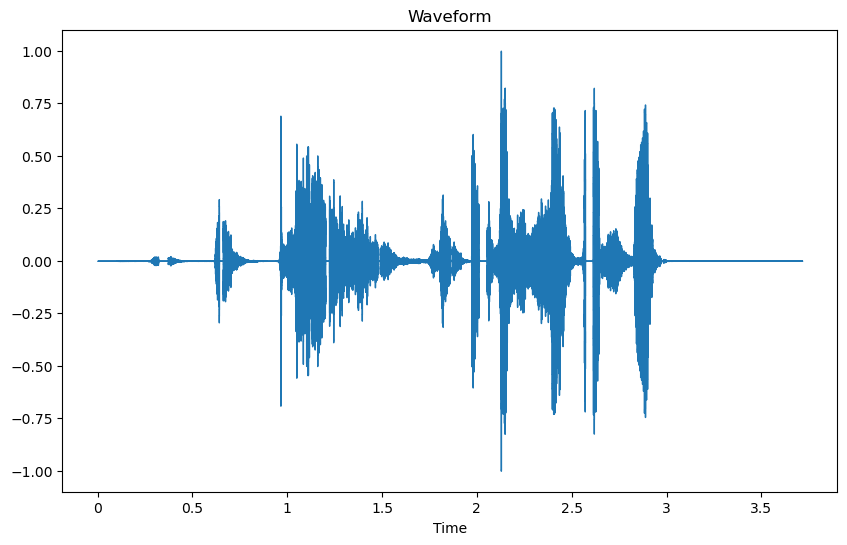

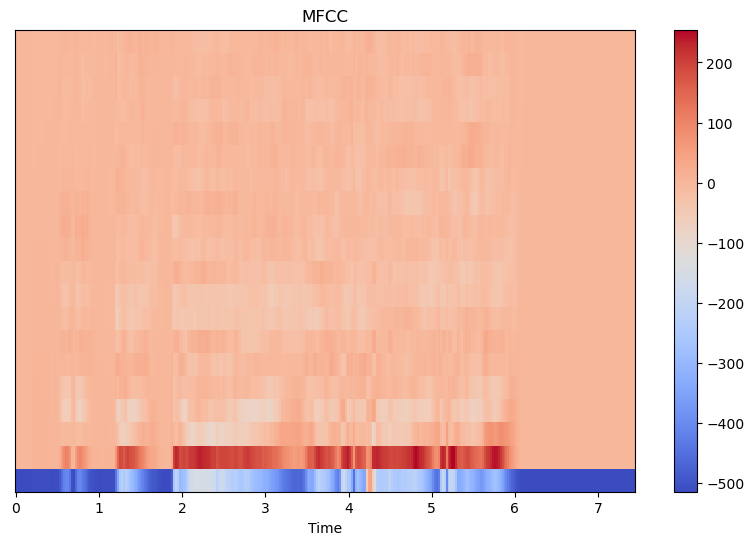

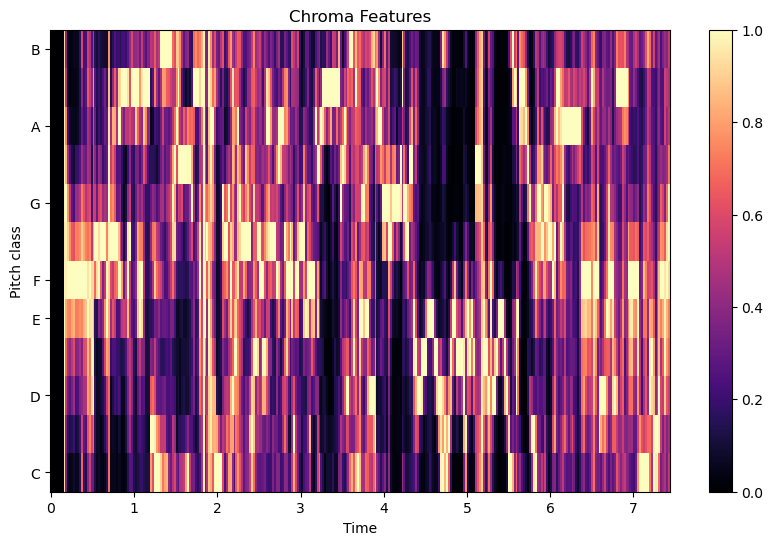

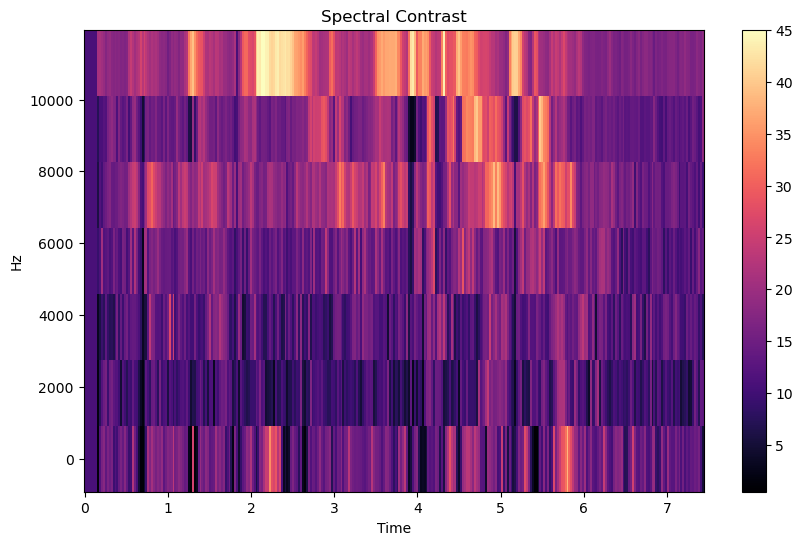

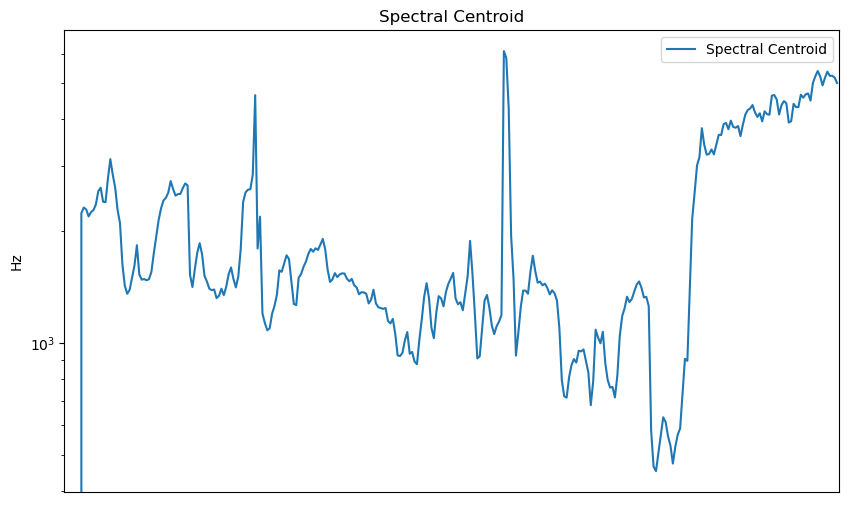

{'duration': 3.7151927437641725, 'mean_rms': 0.054136373, 'mean_zero_crossing_rate': 0.03961010514018692, 'mean_chroma': 0.43339646, 'mean_spectral_contrast': 16.33561203147759, 'mean_spectral_centroid': 1977.9467952435627}




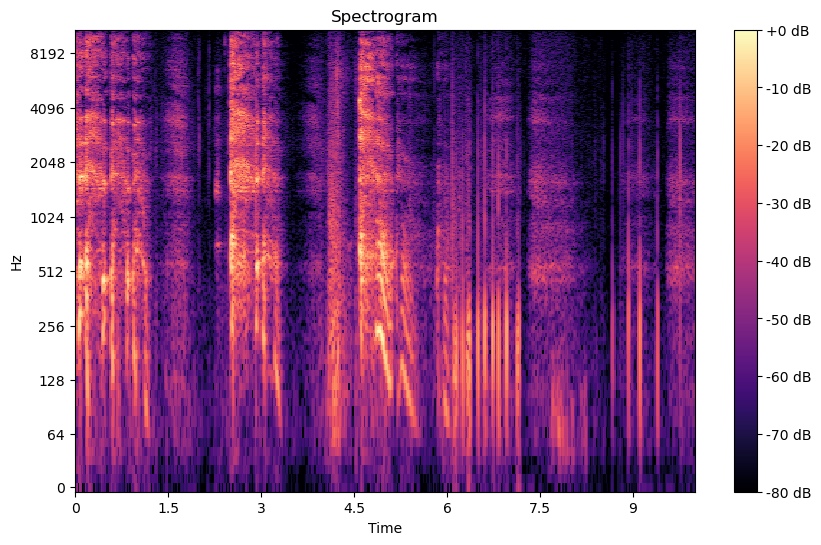

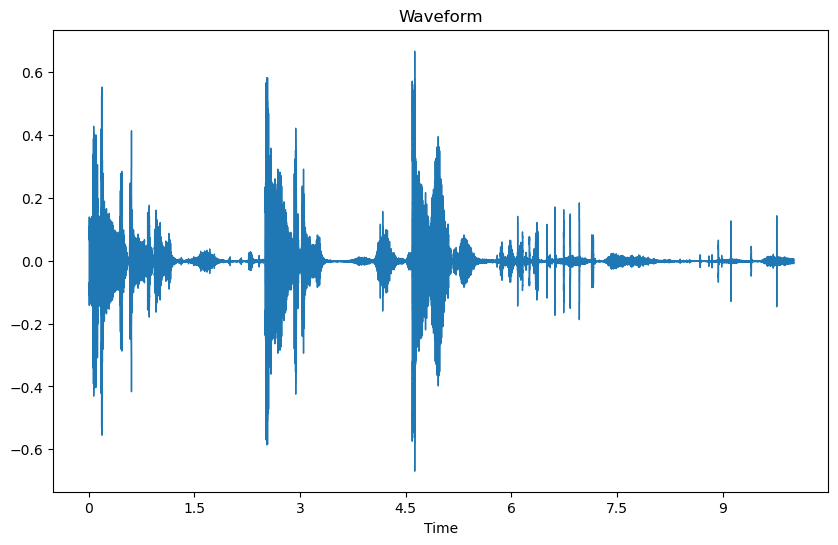

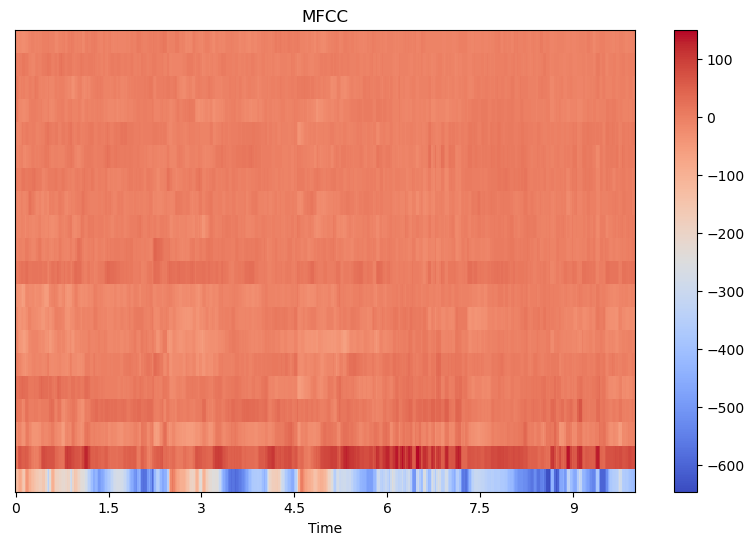

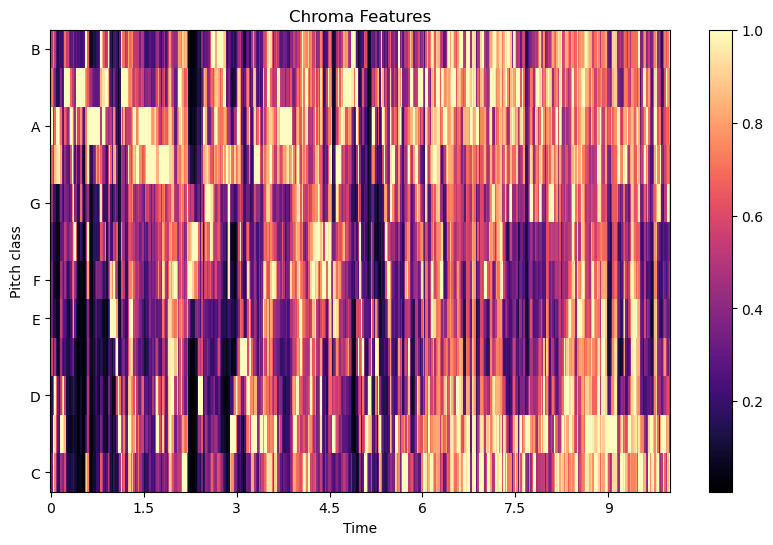

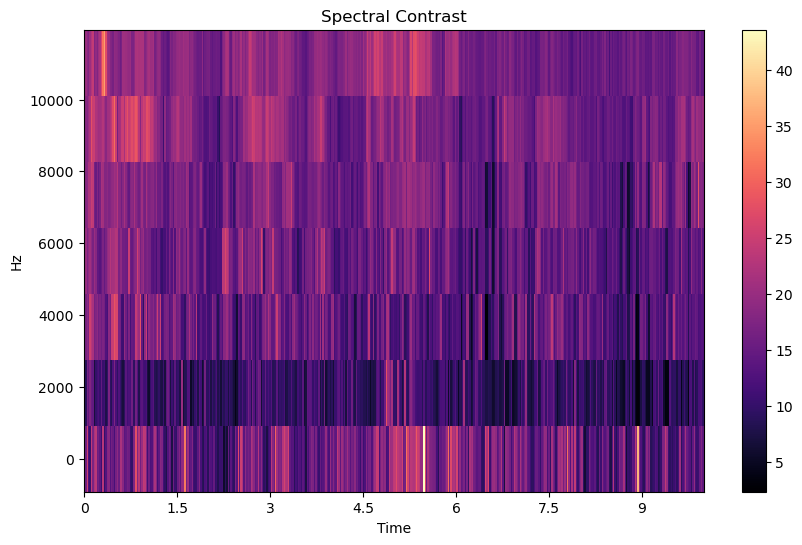

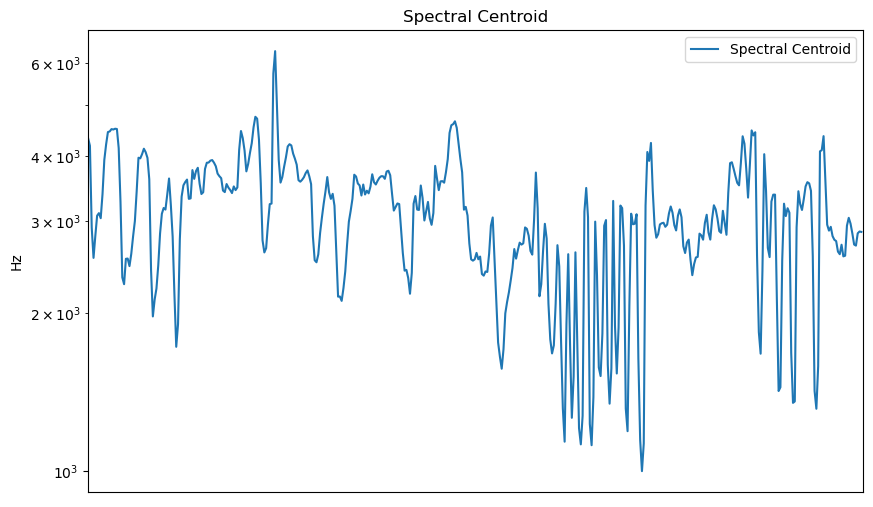

{'duration': 10.0, 'mean_rms': 0.021109048, 'mean_zero_crossing_rate': 0.19841778748549885, 'mean_chroma': 0.553877, 'mean_spectral_contrast': 15.366980749995362, 'mean_spectral_centroid': 3050.3096914739713}




In [3]:
covid = analyze_audio("/kaggle/input/coughclassifier-trial/trial_covid/cov1.wav")
print(covid)
print("\n")


not_covid = analyze_audio("/kaggle/input/coughclassifier-trial/trial_covid/1MSYO4wgiag_ 120.000_ 130.000.wav")
print(not_covid)
print("\n")

In [4]:
def preprocess_audio(fn_wav):
    y, sr = librosa.load(fn_wav, mono=True, duration=5)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    rmse = librosa.feature.rms(y=y)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    
    feature_row = {        
        'chroma_stft': np.mean(chroma_stft),
        'rmse': np.mean(rmse),
        'spectral_centroid': np.mean(spectral_centroid),
        'spectral_bandwidth': np.mean(spectral_bandwidth),
        'rolloff': np.mean(rolloff),
        'zero_crossing_rate': np.mean(zcr),        
    }
    for i, c in enumerate(mfcc):
        feature_row[f'mfcc{i+1}'] = np.mean(c)

    return feature_row

In [5]:
df = pd.read_csv("/kaggle/input/coughclassifier-trial/cough_trial_extended.csv")
df.head()

,file_properties,class
0,0v8MGxNetjg_ 10.000_ 20.000.wav,not_covid
1,1j1duoxdxBg_ 70.000_ 80.000.wav,not_covid
2,1MSYO4wgiag_ 120.000_ 130.000.wav,not_covid
3,1PajbAKd8Kg_ 0.000_ 10.000.wav,not_covid
4,cov1.wav,covid


In [6]:
df.shape

(170, 2)

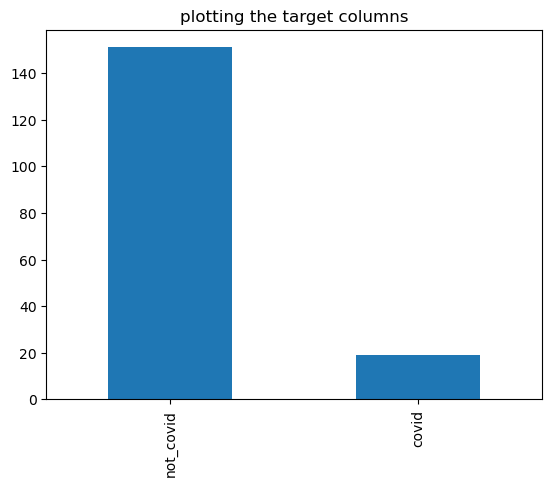

In [7]:
df['class'].value_counts().plot(kind="bar")
plt.title("plotting the target columns")
plt.show()

In [8]:
from tqdm import tqdm


df_features_cols = ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate']
for i in range(1, 21):
    df_features_cols.append(f'mfcc{i}')
df_features_cols.append('label')

df_features = pd.DataFrame(columns=df_features_cols)

for row_index, row in tqdm(df.iterrows(), total=len(df)):
    fn_wav = os.path.join('/kaggle/input/coughclassifier-trial/trial_covid/', row['file_properties'])
    feature_row = preprocess_audio(fn_wav)
    feature_row['filename'] = row['file_properties']
    feature_row['label'] = row['class']
    df_features = df_features.append(feature_row, ignore_index=True)

df_features.to_csv('/kaggle/working/prepared_data_kaggle.csv', index=False, columns=df_features_cols)

df_features.head()

100%|██████████| 170/170 [00:25<00:00,  6.72it/s]


,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0v8MGxNetjg_ 10.000_ 20.000.wav,0.520202,0.045849,1613.207268,1412.419947,2908.029175,0.107019,-377.008667,110.928291,-31.870615,...,-7.442677,-1.042071,-0.211678,-3.513029,-1.755284,-3.029744,-2.873752,-2.084186,-4.006258,not_covid
1,1j1duoxdxBg_ 70.000_ 80.000.wav,0.535920,0.001767,2892.900311,2467.700045,5074.209595,0.148584,-519.298096,60.833210,-13.686949,...,-0.897269,7.246154,-1.711322,3.879874,3.637301,3.026382,2.439105,2.778507,2.209200,not_covid
2,1MSYO4wgiag_ 120.000_ 130.000.wav,0.495701,0.033442,3429.345493,2788.624736,6887.833659,0.225315,-282.546631,48.550930,-15.530040,...,-6.072834,-4.181358,0.995803,-0.526878,0.544948,-8.846841,-2.909318,-1.115006,-5.921741,not_covid
3,1PajbAKd8Kg_ 0.000_ 10.000.wav,0.407945,0.013446,2710.614837,2664.172992,5778.325399,0.142076,-346.925903,75.774315,-7.640137,...,5.065131,-0.284328,0.986260,-2.453420,3.691722,2.317096,-2.061888,-4.779807,-0.513034,not_covid
4,cov1.wav,0.419485,0.059004,1582.273464,1444.530878,2928.047512,0.152013,-340.571655,104.133537,-32.205326,...,-8.268666,0.961192,-5.721939,-6.306130,-1.100168,-1.792879,-2.538296,-3.665395,-3.582565,covid


In [9]:
df_features.columns

Index(['filename', 'chroma_stft', 'rmse', 'spectral_centroid',
       'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2',
       'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10',
       'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17',
       'mfcc18', 'mfcc19', 'mfcc20', 'label'],
      dtype='object')

In [10]:
print('Total number of examples:', len(df_features))
print('Number of positive examples:', len(df_features[df_features['label'] == 'covid']))
print('Number of negative examples:', len(df_features[df_features['label'] == 'not_covid']))

Total number of examples: 170
Number of positive examples: 19
Number of negative examples: 151


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
import optuna

In [12]:
# Separate features and labels
X = df_features.iloc[:, 1:-1]
y = df_features.iloc[:, -1]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, plot_roc_curve
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, plot_roc_curve
import matplotlib.pyplot as plt

# Define a function to train and evaluate a classifier
def train_and_evaluate_classifier(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("ROC AUC Score:")
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(roc_auc)

    # Plot ROC curve
    fig, ax = plt.subplots()
    plot_roc_curve(classifier, X_test, y_test, ax=ax)
    plt.title(f'ROC AUC Plot for {classifier.__class__.__name__}')
    plt.show()


In [14]:
def objective_per_classifier(trial, classifier_name):
    if classifier_name == "LogisticRegression":
        C = trial.suggest_float("C", 1e-5, 1e5, log=True)
        classifier_obj = LogisticRegression(C=C, random_state=42)
    elif classifier_name == "LGBMClassifier":
        n_estimators = trial.suggest_int("n_estimators", 10, 500)
        max_depth = trial.suggest_int("max_depth", 2, 50)
        classifier_obj = LGBMClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    else:
        n_estimators = trial.suggest_int("n_estimators", 10, 500)
        max_depth = trial.suggest_int("max_depth", 2, 50)
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 1, log=True)
        classifier_obj = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42)

    classifier_obj.fit(X_train_scaled, y_train)
    return classifier_obj.score(X_test_scaled, y_test)

In [15]:
classifier_names = ["LogisticRegression", "LGBMClassifier", "GradientBoostingClassifier"]
best_params = {}

for classifier_name in classifier_names:
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective_per_classifier(trial, classifier_name), n_trials=50)
    best_trial = study.best_trial
    best_params[classifier_name] = best_trial.params

[I 2023-04-12 09:53:50,131] A new study created in memory with name: no-name-a1dc8259-7726-4604-a0e1-aeec23875577
[I 2023-04-12 09:53:50,142] Trial 0 finished with value: 0.8235294117647058 and parameters: {'C': 0.0002650264491384288}. Best is trial 0 with value: 0.8235294117647058.
[I 2023-04-12 09:53:50,152] Trial 1 finished with value: 0.9117647058823529 and parameters: {'C': 1243.4539396332232}. Best is trial 1 with value: 0.9117647058823529.
[I 2023-04-12 09:53:50,158] Trial 2 finished with value: 0.8235294117647058 and parameters: {'C': 0.0005641704618700625}. Best is trial 1 with value: 0.9117647058823529.
[I 2023-04-12 09:53:50,164] Trial 3 finished with value: 0.8235294117647058 and parameters: {'C': 0.004839368915931009}. Best is trial 1 with value: 0.9117647058823529.
[I 2023-04-12 09:53:50,170] Trial 4 finished with value: 0.8529411764705882 and parameters: {'C': 0.12766600381341636}. Best is trial 1 with value: 0.9117647058823529.
[I 2023-04-12 09:53:50,180] Trial 5 finish

In [16]:

# Train and evaluate all classifiers using the best hyperparameters
classifiers = []

# Logistic Regression
best_C = best_params['LogisticRegression']['C']
logistic_regression = LogisticRegression(C=best_C, random_state=42)
classifiers.append(logistic_regression)

# LGBM Classifier
best_n_estimators = best_params['LGBMClassifier']['n_estimators']
best_max_depth = best_params['LGBMClassifier']['max_depth']
lgbm_classifier = LGBMClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, random_state=42)
classifiers.append(lgbm_classifier)

# Gradient Boosting Classifier
best_n_estimators = best_params['GradientBoostingClassifier']['n_estimators']
best_max_depth = best_params['GradientBoostingClassifier']['max_depth']
best_learning_rate = best_params['GradientBoostingClassifier']['learning_rate']
gradient_boosting_classifier = GradientBoostingClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, learning_rate=best_learning_rate, random_state=42)
classifiers.append(gradient_boosting_classifier)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Evaluating LogisticRegression
Classification Report:
              precision    recall  f1-score   support

       covid       0.71      0.83      0.77         6
   not_covid       0.96      0.93      0.95        28

    accuracy                           0.91        34
   macro avg       0.84      0.88      0.86        34
weighted avg       0.92      0.91      0.91        34

Confusion Matrix:
[[ 5  1]
 [ 2 26]]
ROC AUC Score:
0.9523809523809524


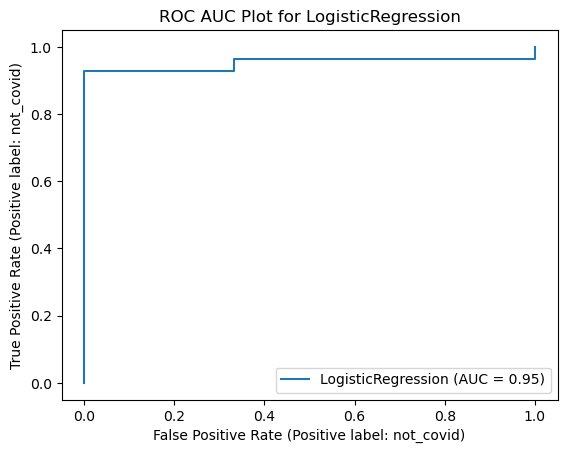



Evaluating LGBMClassifier
Classification Report:
              precision    recall  f1-score   support

       covid       1.00      0.67      0.80         6
   not_covid       0.93      1.00      0.97        28

    accuracy                           0.94        34
   macro avg       0.97      0.83      0.88        34
weighted avg       0.95      0.94      0.94        34

Confusion Matrix:
[[ 4  2]
 [ 0 28]]
ROC AUC Score:
0.9404761904761905


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


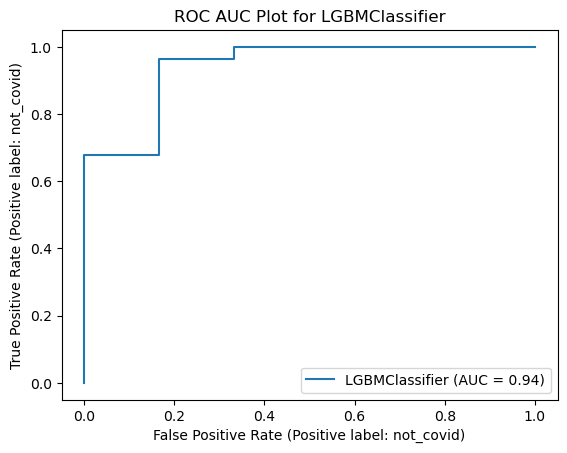



Evaluating GradientBoostingClassifier
Classification Report:
              precision    recall  f1-score   support

       covid       1.00      0.67      0.80         6
   not_covid       0.93      1.00      0.97        28

    accuracy                           0.94        34
   macro avg       0.97      0.83      0.88        34
weighted avg       0.95      0.94      0.94        34

Confusion Matrix:
[[ 4  2]
 [ 0 28]]
ROC AUC Score:
0.9255952380952381


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


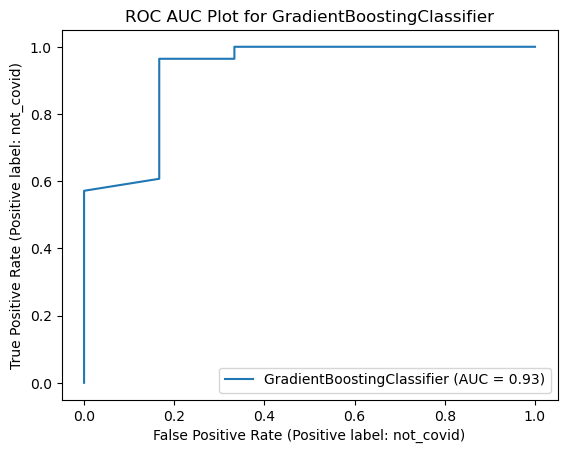

In [17]:
# Evaluate each classifier
for classifier in classifiers:
    print(f"Evaluating {classifier.__class__.__name__}")
    train_and_evaluate_classifier(classifier, X_train_scaled, y_train, X_test_scaled, y_test)
    print("\n")

In [18]:
import pickle

# Save the best model (Logistic Regression) as a pickle file
with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(logistic_regression, f)